In [150]:
import pycda
from pycda.cost_distance_grid import CostDistanceGrid
from pycda.cost_distance_directional import CostDistanceDirectional
import rioxarray
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import LineString

In [151]:
# load sample data (dem, points, stream)

In [158]:
class CostDistance:

    def __init__(self, method, cost_raster, walls=None, enforce_uphill=False, enforce_downhill=False):
        if method == "omnidirectional":
            self.cdg = CostDistanceGrid(cost_raster.data)
            self.cost_raster = cost_raster
        elif method == "directional":
            self.cdg = CostDistanceDirectional(cost_raster.data, walls, enforce_uphill, enforce_downhill)
            self.cost_raster = cost_raster
        else:
            raise ValueError("Invalid method")

    def trace_path(self, source, target):
        # source and target are shapely Points
        source = self._point_to_rowcol(source)
        target = self._point_to_rowcol(target)
        path = self.cdg.trace_path(source, target)
        return self._path_to_linestring(path)

    def cost_accumulation(self, sources):
        # sources is gpd.GeoSeries(points) or boolean_array
        if isinstance(sources, np.ndarray):
            sources_list = self._raster_to_rowcols(sources)
        elif isinstance(sources, geopandas.geoseries.GeoSeries):
            sources_list = [self._point_to_rowcol(p) for p in sources]
        else:
            raise ValueError("invalid input")
        return self.cdg.cost_accumulation(sources_list)

    def _point_to_rowcol(self, point):
        transform = rasterio.transform.AffineTransformer(self.cost_raster.rio.transform())
        row,col = transform.rowcol(point.x, point.y)
        return (row,col)

    def _rowcol_to_point(self, row, col):
        transform = rasterio.transform.AffineTransformer(self.cost_raster.rio.transform())
        x,y = transform.xy(row, col)
        return Point(x,y)

    def _raster_to_rowcols(self, boolean_array):
        return np.transpose((boolean_array).nonzero()).tolist()

    def _path_to_linestring(self, rowcols):
        points = [self._rowcol_to_point(row, col) for row, col in rowcols]
        return LineString(points)
        

In [159]:
dem = rioxarray.open_rasterio("./sampledata/180500203/subcatchment/dem.tif", masked=True).squeeze()
streams = rioxarray.open_rasterio("./sampledata/180500203/subcatchment/flowpath.tif", masked=True).squeeze()
points = gpd.GeoSeries.from_file("./sampledata/180500203/subcatchment/points.shp")

In [160]:
cda = CostDistance(method='directional', cost_raster = dem, walls= np.isnan(dem.data))

In [161]:
path = cda.trace_path(points[0], points[1])

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

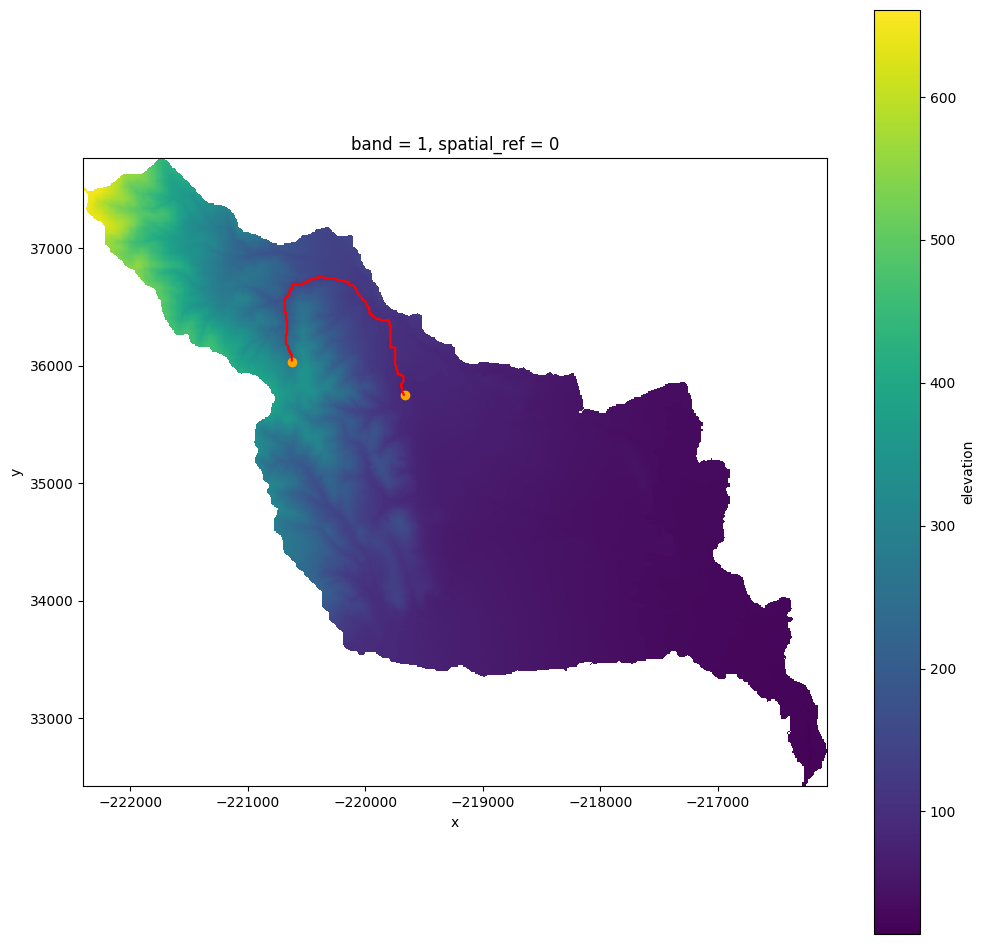

In [162]:
fig, ax = plt.subplots(figsize=(12,12))
dem.plot(ax=ax)
gpd.GeoSeries(path, crs='3310').plot(ax=ax, color='red')
points.plot(ax=ax, color='orange')

In [163]:
cost_accumulation, basins = cda.cost_accumulation(streams.data >0)

In [165]:
cost_accumulation.shape

(338637,)

In [170]:
np.isnan(dem).sum()

<xarray.DataArray ()> Size: 8B
array(214487)
Coordinates:
    band         int64 8B 1
    spatial_ref  int64 8B 0

In [172]:
dem.size - np.isnan(dem.data).sum()

124168

In [173]:
dem.size

338655

In [174]:
dem.shape

(535, 633)

In [175]:
cost_accumulation

array([        inf,         inf,         inf, ..., 24.4839884 ,
       27.56064798, 29.26877745])

In [182]:
test = np.full(dem.shape, np.nan)

In [184]:
len(cost_accumulation)

338637

In [185]:
test.size

338655

In [186]:
cda.cdg.graph

<338637x338637 sparse matrix of type '<class 'numpy.float64'>'
	with 986674 stored elements in Compressed Sparse Row format>

In [187]:
cda.cdg.dem.size

338655

In [188]:
cda.cdg.walls.sum()

214487

In [192]:
cda.cdg.graph.todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 4.00490761,
         0.        ],
        [0.        , 0.        , 0.        , ..., 4.00490761, 0.        ,
         2.30267715],
        [0.        , 0.        , 0.        , ..., 0.        , 2.30267715,
         0.        ]])

In [194]:
gd = cda.cdg._create_graph_data_numba(cda.cdg.dem, cda.cdg.walls, False, False)

In [197]:
len(gd[0])

986674